In [2]:
import sys
sys.path.append('/opt/ml/code/stage1')

In [3]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm.notebook import tqdm
import os
import torch
import timm

from stage1.modules import models

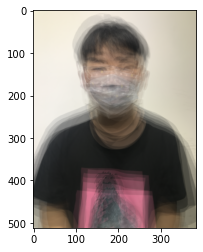

In [28]:
random_folder = glob('/opt/ml/input/data/train/images/*')[np.random.randint(2600)]

images_in_random_folder = glob(os.path.join(random_folder, '*'))
sample_image = images_in_random_folder[1]
sample_image = cv2.imread(sample_image)

mixup = np.zeros_like(sample_image, dtype=np.float64)
for image in images_in_random_folder:
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.
    
    mixup += image

mixup /= 7
plt.imshow(mixup)
plt.show()

['/opt/ml/input/data/train/images/003279_female_Asian_19/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/003279_female_Asian_19/mask1.jpg',
 '/opt/ml/input/data/train/images/003279_female_Asian_19/mask2.jpg',
 '/opt/ml/input/data/train/images/003279_female_Asian_19/mask3.jpg',
 '/opt/ml/input/data/train/images/003279_female_Asian_19/mask4.jpg',
 '/opt/ml/input/data/train/images/003279_female_Asian_19/mask5.jpg',
 '/opt/ml/input/data/train/images/003279_female_Asian_19/normal.jpg']

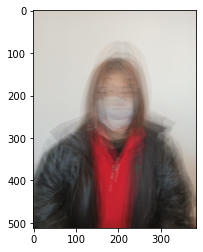

In [46]:
cnt_dict = dict()
for folder in glob(train_origin_path + '/*'):
    for image_file in glob(folder + '/*'):
        ext = image_file.split('.')[-1]
        cnt_dict[ext] = cnt_dict.get(ext, 0) + 1
print(cnt_dict)

{'jpg': 18035, 'jpeg': 354, 'png': 511}


In [47]:
g = glob(os.path.join(train_image_path, '*.jpg'))
len(g)

0

In [48]:
info = pd.read_csv(os.path.join(train_path, 'train.csv'))
info.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [49]:
len(info)

2700

In [50]:
len(info.id.unique())

2699

In [51]:
len(info.path.unique())

2700

In [52]:
info.id.value_counts()

003397    2
005268    1
001987    1
005429    1
001201    1
         ..
001516    1
003266    1
005409    1
001739    1
004487    1
Name: id, Length: 2699, dtype: int64

In [53]:
info[info.id == '003397']

,id,gender,race,age,path
1366,003397,female,Asian,20,003397_female_Asian_20
1367,003397,female,Asian,19,003397_female_Asian_19


In [54]:
2700 * 7

18900

In [55]:
info.iloc[-1]

id                      006959
gender                    male
race                     Asian
age                         19
path      006959_male_Asian_19
Name: 2699, dtype: object

In [56]:
g[1]

IndexError: list index out of range

In [57]:
idx = np.random.randint(len(g))
sample = cv2.imread(g[idx])
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
plt.imshow(sample)
plt.show()

ValueError: low >= high

In [58]:
sample.shape

(512, 384, 3)

In [59]:
glob(os.path.join(train_image_path, '02*'))[:5]

[]

ValueError: low >= high

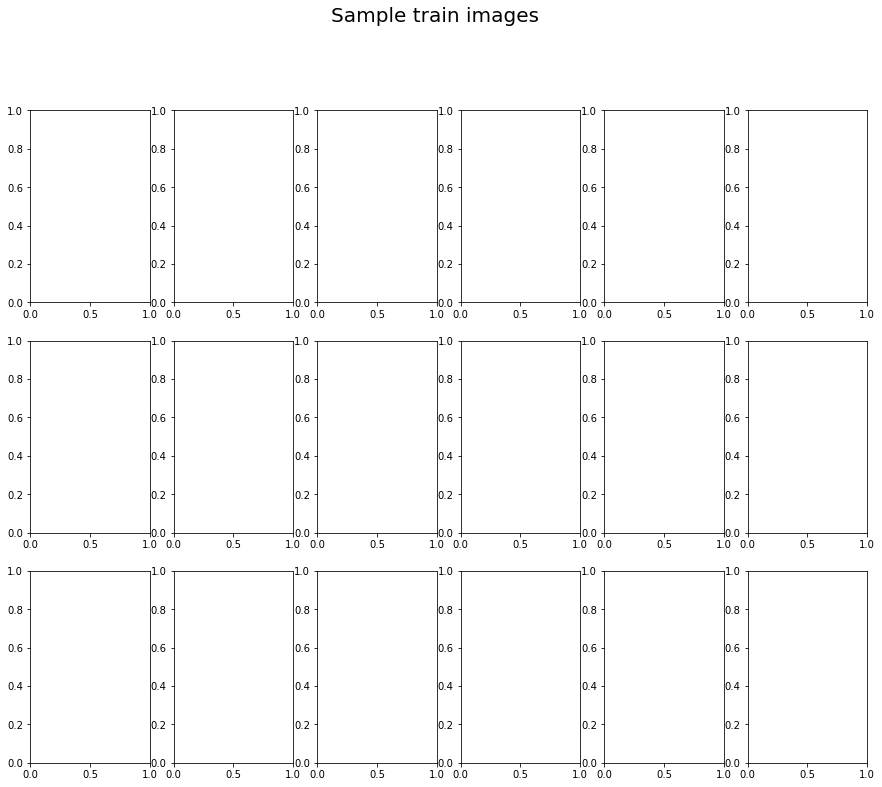

In [60]:
def sample_image(label):
    label = f'{label:02d}'
    candidates = glob(os.path.join(train_image_path, f'{label}*'))
    idx = np.random.randint(len(candidates))
    image = cv2.imread(candidates[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

fig, axes = plt.subplots(3, 6, figsize=(15, 12))
fig.suptitle("Sample train images", fontsize=20, y=1)
for label in range(18):
    r, c = divmod(label, 6)
    subfig = axes[r, c]
    subfig.imshow(sample_image(label))
    subfig.set_title(str(label))
    subfig.axis('off')
plt.tight_layout()
plt.show()

In [64]:
test_images = glob(os.path.join(eval_image_path, '*.jpg'))
test_size = len(test_images)
fig, axes = plt.subplots(3, 6, figsize=(15, 12))
fig.suptitle("Sample test images", fontsize=20, y=1)
for i in range(18):
    idx = np.random.randint(test_size)
    image = test_images[idx]
    image_name = image.split('/')[-1]
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.
    image = cv2.normalize(image, 0, 255)
    r, c = divmod(i, 6)
    subfig = axes[r, c]
    subfig.imshow(image)
    subfig.axis('off')
plt.tight_layout()
plt.show()

NameError: name 'eval_image_path' is not defined

In [ ]:
images_in_folder = glob(os.path.join(train_origin_path, '001554_female_Asian_27', '*'))
images_in_folder

In [ ]:
from skimage.exposure import histogram
from skimage.feature import canny
from scipy import ndimage as ndi
from skimage.filters import sobel
from skimage.segmentation import watershed

In [ ]:
sample = test_images[np.random.randint(len(test_images))]
sample = cv2.imread(sample)
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
hist, hist_centers = histogram(sample)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(hist)
axes[1].plot(hist_centers)
plt.show()

In [ ]:
edges = canny(sample/255.)
plt.imshow(edges)

In [ ]:
from skimage.feature import canny
from scipy import ndimage as ndi
from skimage.filters import sobel
from skimage.segmentation import watershed

all_folders = glob(os.path.join(train_origin_path, '*'))
# random_folder = all_folders[np.random.randint(len(all_folders))]
random_folder = "/opt/ml/input/data/train/images/001554_female_Asian_27"
images_in_folder = glob(os.path.join(random_folder, '*'))

hist = []
hist_n = []

fig, axes = plt.subplots(2, 7, figsize=(14, 5), sharex=True, sharey=True)
fig.suptitle(random_folder.split('/')[-1], fontsize=15, y=1.025)
for i, image_file in enumerate(images_in_folder):
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = image / 255.
    image_n = cv2.normalize(image, 0, 255, cv2.NORM_MINMAX)
    
    hist.append(np.mean(image[0], axis=1))
    hist_n.append(np.mean(image_n[0], axis=1))

    axes[0, i].imshow(image)
    axes[1, i].imshow(image_n)
    
    axes[0, i].axis('off')
    axes[1, i].axis('off')
    
plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns

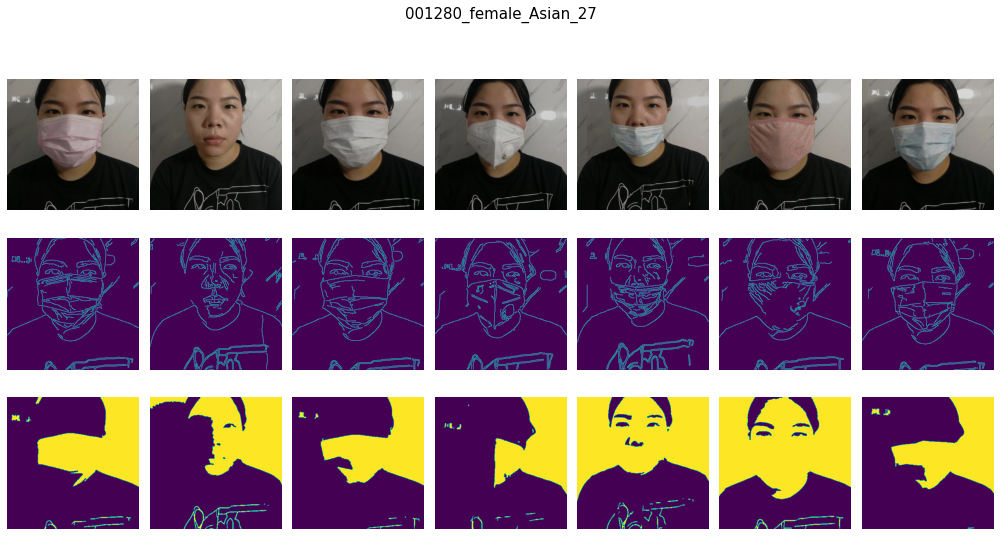

In [61]:
from skimage.feature import canny
from scipy import ndimage as ndi
from skimage.filters import sobel
from skimage.segmentation import watershed

all_folders = glob(os.path.join(train_origin_path, '*'))
random_folder = all_folders[np.random.randint(len(all_folders))]
images_in_folder = glob(os.path.join(random_folder, '*'))

fig, axes = plt.subplots(3, 7, figsize=(14, 7.5), sharex=True, sharey=True)
fig.suptitle(random_folder.split('/')[-1], fontsize=15, y=1.025)
for i, image_file in enumerate(images_in_folder):
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    h, w, _ = image.shape
    cropped = image[h-w:h, 0:w, :]
    gray = cv2.cvtColor(cropped, cv2.COLOR_RGB2GRAY)

    cropped = cropped / 255.
    cropped = cv2.normalize(cropped, 0, 255)

    gray = gray / 255.
    edges = canny(gray)
    
    threshold = (0.28, 0.72)
    markers = np.zeros_like(gray)
    markers[gray < threshold[0]] = 1
    markers[gray > threshold[1]] = 2
    elevation_map = sobel(gray)
    segmentation = watershed(elevation_map, markers)
#     segmentation = ndi.binary_fill_holes(segmentation - 1)

    axes[0, i].imshow(cropped)
    axes[1, i].imshow(edges)
    axes[2, i].imshow(segmentation)
    
    axes[0, i].axis('off')
    axes[1, i].axis('off')
    axes[2, i].axis('off')
    
plt.tight_layout()
plt.show()

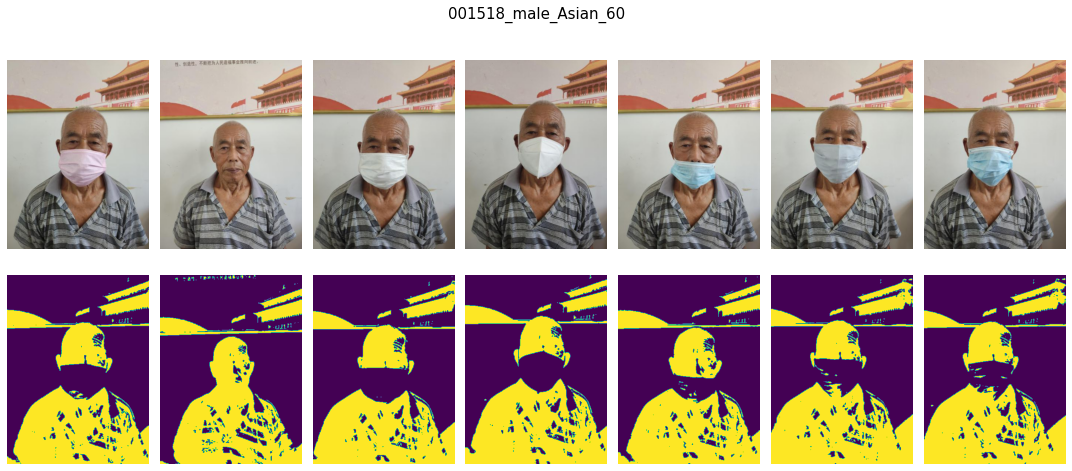

In [62]:
all_folders = glob(os.path.join(train_origin_path, '*'))
random_folder = all_folders[np.random.randint(len(all_folders))]
images_in_folder = glob(os.path.join(random_folder, '*'))

fig, axes = plt.subplots(2, 7, figsize=(15, 7), sharex=True, sharey=True)
fig.suptitle(random_folder.split('/')[-1], fontsize=15)

for i, image_file in enumerate(images_in_folder):
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    blur = cv2.GaussianBlur(image, (3, 3), 0)
    gray = cv2.cvtColor(blur, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((1, 1), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=3)
    sure_bg = cv2.dilate(opening, kernel, iterations=1)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 3)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.int8(sure_fg)

#     image = image / 255.
#     image_n = cv2.normalize(image, 0, 255)
    image_r = face_recognition.load_image_file(image_file)
    image_r = face_recognition.face_locations(image_r)
    axes[0, i].imshow(image)
    axes[0, i].axis('off')
    axes[1, i].imshow(sure_bg)
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

In [63]:
stats = dict()
for label in range(18):
    group = glob(os.path.join(train_image_path, f"{label:02d}*"))
    stats[label] = len(group)

male, female = 0, 0
correct, incorrect, normal = 0, 0, 0
low, mid, high = 0, 0, 0
for label in stats:
    stat = stats[label]
    
    if label % 6 < 3:
        male += stat
    else:
        female += stat
        
    if label % 3 == 0:
        low += stat
    elif label % 3 == 1:
        mid += stat
    else:
        high += stat
        
    if label < 6:
        correct += stat
    elif label < 12:
        incorrect += stat
    else:
        normal += stat

sum_gender = sum([male, female])
sum_age = sum([low, mid, high])
sum_mask = sum([correct, incorrect, normal])
print(f"Gender   {male / sum_gender:.3f} {female / sum_gender:.3f}")
print(f"Age      {low / sum_age:.3f} {mid / sum_age:.3f} {high / sum_age:.3f}")
print(f"Mask     {correct / sum_mask:.3f} {incorrect / sum_mask:.3f} {normal / sum_mask:.3f}")

ZeroDivisionError: division by zero

In [ ]:
dist = []
for stat in stats.values():
    dist.append(stat)

plt.bar(range(18), dist)
plt.xticks(range(18), range(18))
plt.show()

In [ ]:
sum(dist)

In [ ]:
list(map(lambda x: max(dist) // x, dist))